# Project Description

### Objective

Develop a reliable generative search system that can efficiently and precisely respond to queries based on provided policy document (a single long life insurance policy document).

### Design

Solution will broadly contain three layers:

**The Embedding Layer**: The PDF document needs to be effectively processed, cleaned, and chunked for the embeddings. As PDF is  large blocks of text, before generating the embeddings, you need to generate the chunksHere, the choice of the chunking strategy will have a large impact on the final quality of the retrieved results. So, make sure that you try out various stratgies and compare their performances.

Another important aspect in the embedding layer is the choice of the embedding model. You can choose to embed your chunks using the OpenAI embedding model or any model from the SentenceTransformers library on HuggingFace.

**The Semantic Search Layer**: Here, you first need to design at least 3 queries against which you will test your system. You need to understand and skim through the document, and accordingly come up with some queries, the answers to which can be found in the policy document.

Next, you need to embed the queries and search your ChromaDB vector database against each of these queries. Implementing a cache mechanism is also mandatory.

Finally, you need to implement the re-ranking block, and for this you can choose from a range of cross-encoding models on HuggingFace.

**The Generation Layer**: In the generation layer, the final prompt that you design is the major component. Make sure that the prompt is exhaustive in its instructions, and the relevant information is correctly passed to the prompt. You may also choose to provide some few-shot examples in an attempt to improve the LLM output.


**Design Diagram**:
![image.png](attachment:image.png)

### Import libraries and installations

In [1]:
# Pip install libraries
!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 14.4 MB/s eta 0

In [2]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
from openai import OpenAI
import os
import openai

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
## Add your OPENAI API KEY
filepath = "/content/drive/Othercomputers/My Laptop/AI-ML/EPG - AIML/GEN AI/Vector DB and RAG/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())
os.environ['OPENAI_API_KEY'] = openai.api_key

### Step 1: The Embedding Layer: Extract data and Generate Embeddings

Embedding layer plays a critical role in both the retrieval and generation phases
Purpose of the Embedding Layer in RAG-Based Solutions:
1. Semantic Representation
2. Efficient Retrieval
3. Contextual Understanding
4. Handling Large-Scale Data

![image.png](attachment:image.png)

#### 1. Extract data from PDF

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [6]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

# Function to check whether a word is present in a table or not for segregation of regular text and tables
def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [7]:
# Load the dataset
filepath = "/content/drive/Othercomputers/My Laptop/AI-ML/EPG - AIML/GEN AI/HelpMate AI/"
# Define the directory containing the PDF files
pdf_directory = Path(filepath)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [8]:
extracted_text_df

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


As we can see some pages are blank, and have content "This page left blank intentionally", we can drop them as there is no relevant data in it

In [9]:
extracted_text_df = extracted_text_df[extracted_text_df["Page_Text"] != ""]
extracted_text_df = extracted_text_df[extracted_text_df["Page_Text"] != "This page left blank intentionally"]
extracted_text_df.reset_index(drop=True, inplace=True)
len(extracted_text_df)

61

In [10]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
extracted_text_df['Text_Length'] = extracted_text_df['Page_Text'].apply(lambda x: len(x.split(' ')))

In [11]:
extracted_text_df["Text_Length"].describe()

,Text_Length
count,61.000000
mean,276.344262
std,114.168426
min,8.000000
25%,214.000000
50%,291.000000
75%,367.000000
max,462.000000


In [12]:
# There are pages with text length as 5 so removing them

extracted_text_df = extracted_text_df.loc[extracted_text_df['Text_Length'] >= 10]
extracted_text_df.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


In [13]:
extracted_text_df.shape

(60, 4)

#### 2. Data Chunking

Since we are using large blocks of text, before generating the embeddings, we should generate the chunks.

We explore below chunking strategies:

1. Fixed size chunking with overlap
2. Chunking by Page
3. Chunking by Sections (Domain will enhance the quality of data stored)

Base thought process behind data chunking

##### Chunking for multiple documents

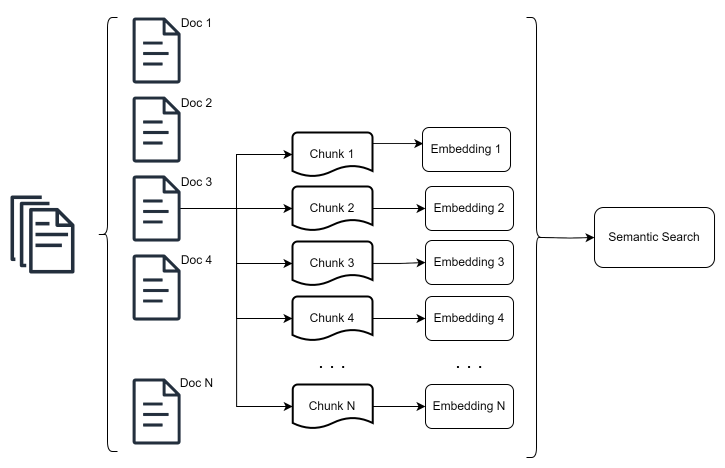

##### Fixed Length Chunking

In [14]:
extracted_text_df.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176


In [15]:
chunk_size = 300  # Set your desired chunk size (in characters)

from typing import List

# Split the text into units (words, in this case)
def word_splitter(source_text: str) -> List[str]:
    import re
    source_text = re.sub("\s+", " ", source_text)  # Replace multiple whitespces
    return re.split("\s", source_text)  # Split by single whitespace

def get_chunks_fixed_size_with_overlap(text: str, chunk_size: int, overlap_fraction: float) -> List[str]:
    text_words = word_splitter(text)
    overlap_int = int(chunk_size * overlap_fraction)
    chunks = []
    for i in range(0, len(text_words), chunk_size):
        chunk_words = text_words[max(i - overlap_int, 0): i + chunk_size]
        chunk = " ".join(chunk_words)
        chunks.append(chunk)
    return chunks

In [16]:
source_text = " \n".join(extracted_text_df["Page_Text"])

In [17]:
chunks = get_chunks_fixed_size_with_overlap(source_text, chunk_size, overlap_fraction=0.2)

In [18]:
len(chunks)

57

In [19]:
fixed_length_chunks_df = pd.DataFrame(chunks, columns=["Chunk_Text"])
fixed_length_chunks_df["Document Name"] = pdf_path.name

In [20]:
fixed_length_chunks_df.head()

,Chunk_Text,Document Name
0,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,PROVISIONS WILL BE AS DESCRIBED IN THE GROUP P...,Principal-Sample-Life-Insurance-Policy.pdf
2,Dependent Life Insurance Article 3 Section B -...,Principal-Sample-Life-Insurance-Policy.pdf
3,Examinations Article 5 Autopsy Article 6 Legal...,Principal-Sample-Life-Insurance-Policy.pdf
4,to maintain a reasonable level of personal hyg...,Principal-Sample-Life-Insurance-Policy.pdf


##### Chunking by Page

We already have data arranged page wise the dataframe, lets check the number of words in each chunk, and number of chunks to be embedded if we do page wise embedding

In [21]:
page_chunk_df = extracted_text_df
page_chunk_df["Chunk_Text"] =  page_chunk_df["Page_Text"]

In [22]:
page_chunk_df.head(5)

,Page No.,Page_Text,Document Name,Text_Length,Chunk_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
2,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
3,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,TABLE OF CONTENTS PART I - DEFINITIONS PART II...
4,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,Section A – Eligibility Member Life Insurance ...


##### Chunking by Sections

In [23]:
sections = [
    "DEFINITIONS",
    "TABLE OF CONTENTS",
    "TITLE PAGE",
    "POLICY RIDER",
    "POLICY ADMINISTRATION - Contract",
    "POLICY ADMINISTRATION - Premiums",
    "POLICY ADMINISTRATION - Policy Termination",
    "POLICY ADMINISTRATION - Policy Renewal",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Eligibility",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Effective Dates",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Individual Terminations",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Continuation",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Reinstatement",
    "INDIVIDUAL REQUIREMENTS AND RIGHTS - Individual Purchase Rights",
    "BENEFITS - Member Life Insurance",
    "BENEFITS - Member Accidental Death and Dismemberment Insurance",
    "BENEFITS - Dependent Life Insurance",
    "BENEFITS - Claim Procedures"
]

In [24]:
def define_section(extracted_text_df, sections):
    extracted_text_df["Section"] = None
    for i, page in extracted_text_df.iterrows():
        page_text = page["Page_Text"]
        for section in sections:
            found = False
            if section in page_text:
                extracted_text_df.loc[i, "Section"] = section
                found = True
                break
            sub_sections = section.split("-")
            for sub_section in sub_sections:
                if sub_section.strip() in page_text:
                    found = True
                else:
                    found = False
                    break
            if found:
                extracted_text_df.loc[i, "Section"] = section
    extracted_text_df["Section"].fillna("WRAPPER", inplace=True)
    return extracted_text_df

In [25]:
section_chunk_df = define_section(extracted_text_df,sections)
# Append all the text by section (group by section)
section_chunk_df = section_chunk_df.groupby("Section")["Page_Text"].apply(lambda x: " \n".join(x)).reset_index()
section_chunk_df.rename(columns={"Page_Text": "Chunk_Text"}, inplace=True)
section_chunk_df["Document Name"] = pdf_path.name

In [26]:
#Validate the data: Get first row of section_df and read detailed Page_Text
section_chunk_df["Chunk_Text"][0]

'Section D - Claim Procedures Article 1 - Notice of Claim Written notice must be sent to The Principal by or for a Member or Dependent who wishes to file claim for benefits under this Group Policy. This notice must be sent within 20 days after the date of the loss for which claim is being made. Failure to give notice within the time specified will not invalidate or reduce any claim if notice is given as soon as reasonably possible. Article 2 - Claim Forms The Principal, when it receives notice of claim, will provide appropriate claim forms for filing proof of loss. If the forms are not provided within 15 days after The Principal receives notice, the person will be considered to have complied with the requirements of this Group Policy upon submitting, within the time specified below for filing proof of loss, Written proof covering the occurrence, character, and extent of the loss. Article 3 - Proof of Loss Written proof of loss must be sent to The Principal within 90 days after the date

In [27]:
section_chunk_df.head(5)

,Section,Chunk_Text,Document Name
0,BENEFITS - Claim Procedures,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
1,BENEFITS - Dependent Life Insurance,Payment of benefits will be subject to the Ben...,Principal-Sample-Life-Insurance-Policy.pdf
2,BENEFITS - Member Accidental Death and Dismemb...,Section B - Member Accidental Death and Dismem...,Principal-Sample-Life-Insurance-Policy.pdf
3,BENEFITS - Member Life Insurance,PART IV - BENEFITS Section A - Member Life Ins...,Principal-Sample-Life-Insurance-Policy.pdf
4,DEFINITIONS,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf


#### 3. Generate Embeddings and save in ChromaDB

Sentence Transformers are advanced natural language processing models that encode sentences into high-dimensional vectors. These vectors encapsulate the semantic nuances of text, offering a robust foundation for various text-related tasks, such as clustering, classification, and more.

##### The Hugging Face Connection
Hugging Face, a pioneering platform in NLP, hosts an array of pre-trained models, including Sentence Transformers, that can be readily employed for diverse applications. **sentence-transformers** is a library that provides easy methods to compute embeddings (dense vector representations) for sentences, paragraphs and images. Texts are embedded in a vector space such that similar text is close, which enables applications such as semantic search, clustering, and retrieval.

##### Sentence Transformers Models
Hugging Face's [Sentence Transformers collection](https://huggingface.co/sentence-transformers) includes an assortment of models designed to cater to different use cases. From general-purpose models like BERT and RoBERTa to specialized models fine-tuned for specific tasks, the library provides a plethora of choices for generating embeddings that align with your data's context.

##### Open AI Embedding Models

Trying out below models for embedding for comparison:

1. Sentence Transformer - all-MiniLM-L6-v2
2. Openai - text-embedding-ada-002
3. Openai - text-embedding-ada-003

Sentence transformer models can also be picked using Hugging face leaderboard https://huggingface.co/spaces/mteb/leaderboard

In [28]:
# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [29]:
# Get the Chroma client
chroma_client = chromadb.PersistentClient()

In [30]:
from chromadb.utils import embedding_functions
openai_embedding_function = embedding_functions.OpenAIEmbeddingFunction(api_key=openai.api_key, model_name="text-embedding-ada-002")

In [31]:
def create_collection(collection_name,embedding_function):
    # Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
    collection = chroma_client.get_or_create_collection(name=collection_name,embedding_function=embedding_function)
    return collection

def store_embeddings_in_collection(df, collection,embedding_function, hasMetadata=False):
    collection = create_collection(collection,embedding_function)
    # Add the documents, embeddings, and ids into the collection
    # embeddings = []
    # for i in df['Embeddings']:
    #     embeddings.append(i.tolist())

    documents = []
    for i in df['Chunk_Text']:
        documents.append(i)

    if hasMetadata:
        metadatas = []
        for i in df['Metadata']:
            metadatas.append(i)

        collection.add(
            # embeddings = embeddings,
            documents = documents,
            metadatas = metadatas,
            ids = [str(i) for i in range(0, len(df['Chunk_Text']))],
        )
    else:
        collection.add(
            # embeddings = embeddings,
            documents = documents,
            ids = [str(i) for i in range(0, len(df['Chunk_Text']))],
        )
    return collection

Generate Embeddings for all three categories of chunks prepared above using OpenAI

In [32]:
fixed_length_chunks_df_openai = fixed_length_chunks_df.copy(deep=True)
openai_fixed_collection = store_embeddings_in_collection(fixed_length_chunks_df_openai, "OpenAI_FixedLengthChunks",embedding_function=openai_embedding_function)

In [33]:
page_chunk_df_openai = page_chunk_df.copy(deep=True)
openai_page_collection = store_embeddings_in_collection(page_chunk_df_openai, "OpenAI_PageChunks",embedding_function=openai_embedding_function)

In [34]:
section_chunk_df['Metadata'] = section_chunk_df.apply(lambda x: {'Section': x['Section'], 'Policy_Name': x['Document Name'][:-4]}, axis=1)
section_chunk_df_openai = section_chunk_df.copy(deep=True)
openai_section_collection = store_embeddings_in_collection(section_chunk_df_openai, "OpenAI_SectionChunks",embedding_function=openai_embedding_function,hasMetadata=True)

We have created various collections in Chromadb for open ai and sentence transformer, we have created one cache collection for sentence Transformer based embeddings and one for open ai, we will analyze in next segment all these collections and choose the optimized solutions

### Step 2: Semantic Search Layer with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

the design considerations for creating a cache layer in the semantic search system.

Document query --

first search in cache
if find return top k closeset / chunks of k documents the results
if not find search in main vector db
store the new query in cache
if similar query occurs in future, it's easy to return answer
search and index on the main vector db and return top k closeset / chunks of k documents the results

In [35]:
# Create cache collection
cache_collection = create_collection('Insurance_Cache', embedding_function=openai_embedding_function)
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}

In [36]:
# Initialize the rag client with Open AI Section chunk collection
rag_collection = chroma_client.get_or_create_collection(name="OpenAI_SectionChunks", embedding_function=openai_embedding_function)

#### 1. Document Retrieval

In [37]:
# Read the user query
questions = ["What are the specific exclusions listed in this life insurance policy that could prevent a beneficiary from receiving the death benefit?",
             "How does taking a loan against the policy's cash value affect the death benefit and overall policy value?",
             "What options does the policyholder have if they fail to make a premium payment within the grace period?"]

In [38]:
# Implementing Cache in Semantic Search
def search(query, cache_collection, data_collection):
  # Set a threshold for cache searchA
  threshold = 0.2
  number_results = 5
  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()


  # If the distance is greater than the threshold, then return the results from the main collection.
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = data_collection.query(
        query_texts=query,
        n_results=number_results
        )
        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []
        for key, val in results.items():
          if val is None:
            continue
          if key != 'embeddings':
            for i in range(number_results): # Top 3 variable, we can also put as 25 for top_n
              Keys.append(str(key)+str(i))
              Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        print("Not found in cache. Found in main collection.")

        result_dict = {'Metadata': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df

  # If the distance is, however, less than the threshold, you can return the results from cache
  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        print("Found in cache!")

        # Create a DataFrame
        results_df = pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadata': metadatas
        })
        return results_df


In [39]:
results = []
for query in questions:
    results.append({"query":query , "resultDF": search(query, cache_collection, rag_collection)})

Not found in cache. Found in main collection.
Not found in cache. Found in main collection.
Not found in cache. Found in main collection.


#### 2. Re-Ranking results with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

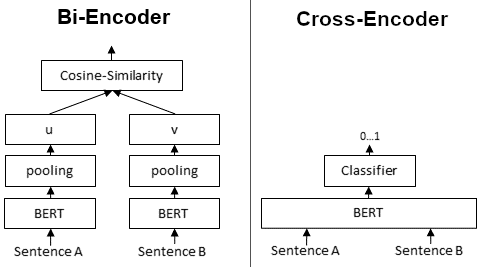

<br>

 the re-ranking stage is the next step in building the semantic search pipeline. So far, in our semantic search application, the system returns the top K documents that contain information relevant to the user’s query. The quality and accuracy of the information contained in these chunks or documents may vary - the system might retrieve documents that are not quite relevant to the search query. The purpose of the re-ranking layer is to sift through these top K results, verify the accuracy of the results in terms of the query and rank them or assign an importance score to these results for the query. Here are some of the benefits of using re-ranking in generative search:
- Improved accuracy and relevance of the generated results
- Reduced amount of irrelevant or inaccurate information presented to the user
- More personalised and informative search results
- Ability to tailor the search results to specific tasks or domains



Traditionally, many methods of re-rank methods have been used in search such as Reciprocal Rank Fusion (RRF), hybrid search methods and cross-encoder models. For this project, we will focus on the popular method of using cross-encoders for our re-ranking task. The image below illustrates the re-ranking component once the search results have been collected by the semantic search layer.

In [40]:
results[0]

{'query': 'What are the specific exclusions listed in this life insurance policy that could prevent a beneficiary from receiving the death benefit?',
 'resultDF':                                             Metadata  \
 0  {'Policy_Name': 'Principal-Sample-Life-Insuran...   
 1  {'Policy_Name': 'Principal-Sample-Life-Insuran...   
 2  {'Policy_Name': 'Principal-Sample-Life-Insuran...   
 3  {'Policy_Name': 'Principal-Sample-Life-Insuran...   
 4  {'Policy_Name': 'Principal-Sample-Life-Insuran...   
 
                                            Documents  Distances IDs  
 0  Section A – Eligibility Member Life Insurance ...   0.325665  16  
 1  Payment of benefits will be subject to the Ben...   0.326788   1  
 2  Section C - Individual Terminations Article 1 ...   0.331538   9  
 3  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   0.336612   4  
 4  PART IV - BENEFITS Section A - Member Life Ins...   0.338738   3  }

In [41]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [42]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
for result in results:
    query = result["query"]
    resultDF = result["resultDF"]
    cross_inputs = [[query, response] for response in resultDF['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)

    resultDF['Reranked_scores'] = cross_rerank_scores

Lets look at the results for first question and impact of reranking on it

In [43]:
# Return the top 3 results from semantic search

top_3_semantic = results[0]["resultDF"].sort_values(by='Distances')
top_3_semantic[:3]

,Metadata,Documents,Distances,IDs,Reranked_scores
0,{'Policy_Name': 'Principal-Sample-Life-Insuran...,Section A – Eligibility Member Life Insurance ...,0.325665,16,-4.214061
1,{'Policy_Name': 'Principal-Sample-Life-Insuran...,Payment of benefits will be subject to the Ben...,0.326788,1,-1.502795
2,{'Policy_Name': 'Principal-Sample-Life-Insuran...,Section C - Individual Terminations Article 1 ...,0.331538,9,-5.518685


In [44]:
# Return the top 3 results after reranking

top_3_rerank = results[0]["resultDF"].sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadata,Documents,Distances,IDs,Reranked_scores
4,{'Policy_Name': 'Principal-Sample-Life-Insuran...,PART IV - BENEFITS Section A - Member Life Ins...,0.338738,3,-0.106175
1,{'Policy_Name': 'Principal-Sample-Life-Insuran...,Payment of benefits will be subject to the Ben...,0.326788,1,-1.502795
0,{'Policy_Name': 'Principal-Sample-Life-Insuran...,Section A – Eligibility Member Life Insurance ...,0.325665,16,-4.214061


In [45]:
top_3_RAG_q1 = top_3_rerank[["Documents", "Metadata"]][:3]
top_3_RAG_q1

,Documents,Metadata
4,PART IV - BENEFITS Section A - Member Life Ins...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,Payment of benefits will be subject to the Ben...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
0,Section A – Eligibility Member Life Insurance ...,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [46]:
# Define a function to extract top 3 documents after reranking for any question
def retrieve_top3withrerank(resultDF):
    top_3_rerank = resultDF.sort_values(by='Reranked_scores', ascending=False)
    return top_3_rerank[["Documents", "Reranked_scores", "Metadata"]][:3]

### Generation Layer

Generation Layer System Design

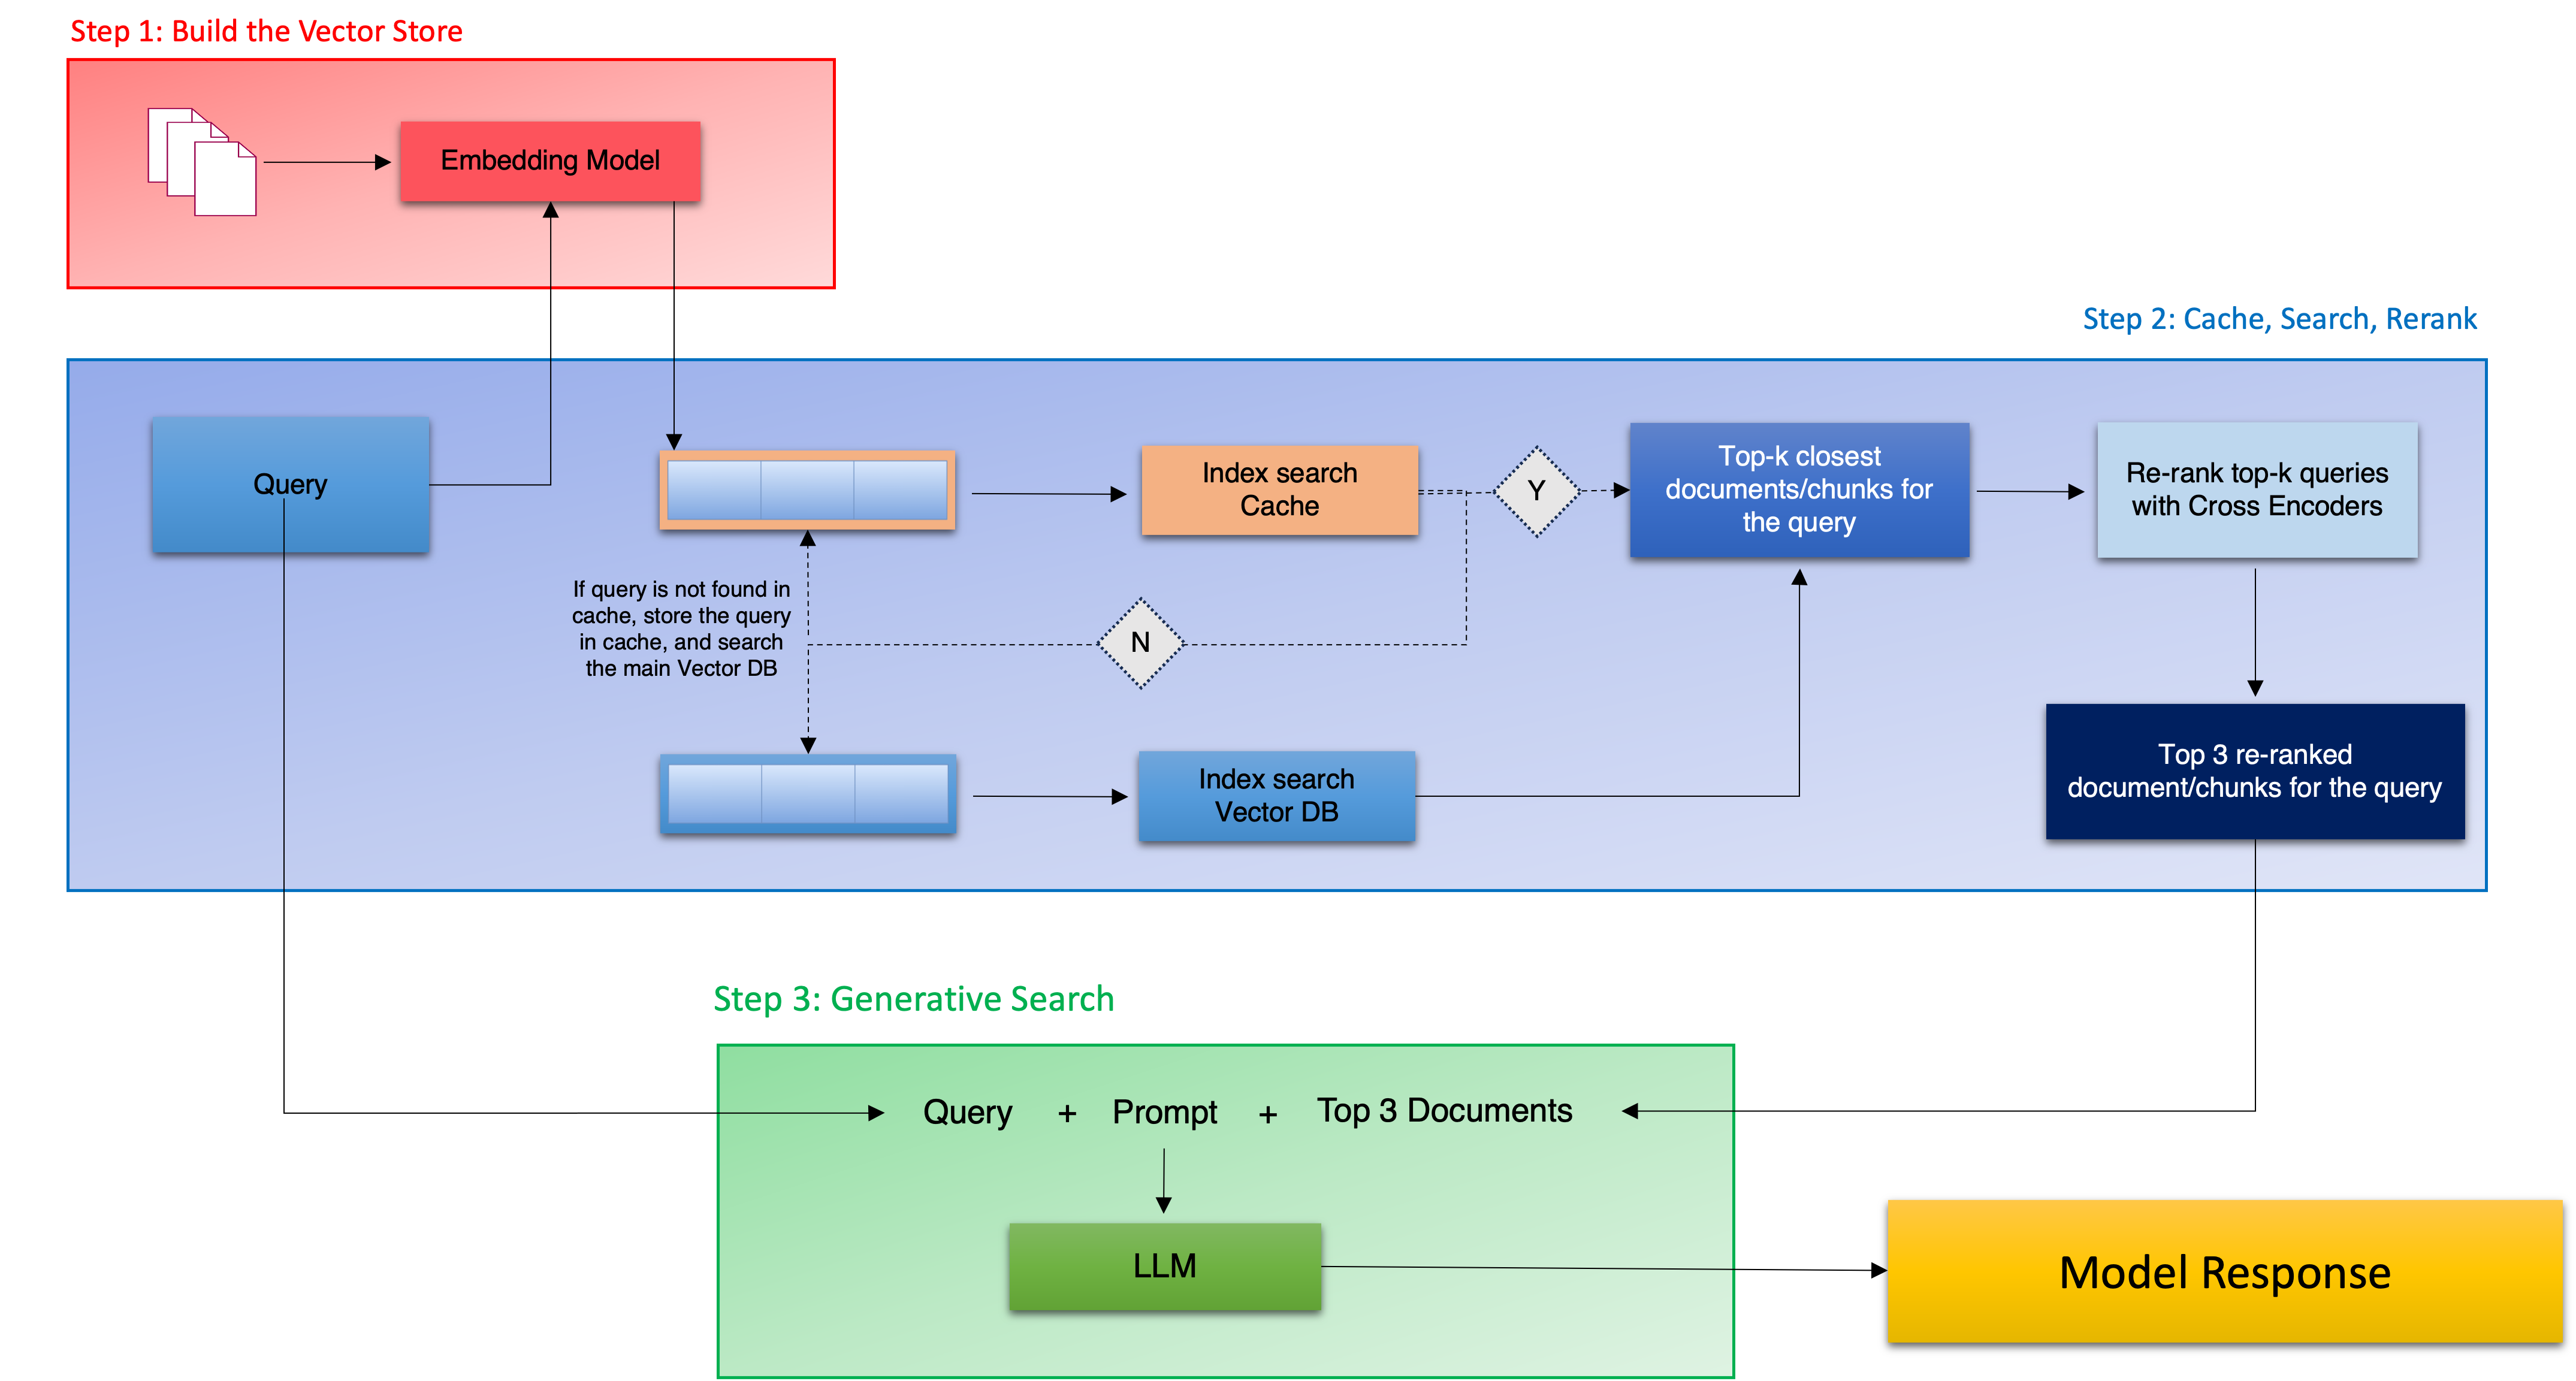

Generation Layer

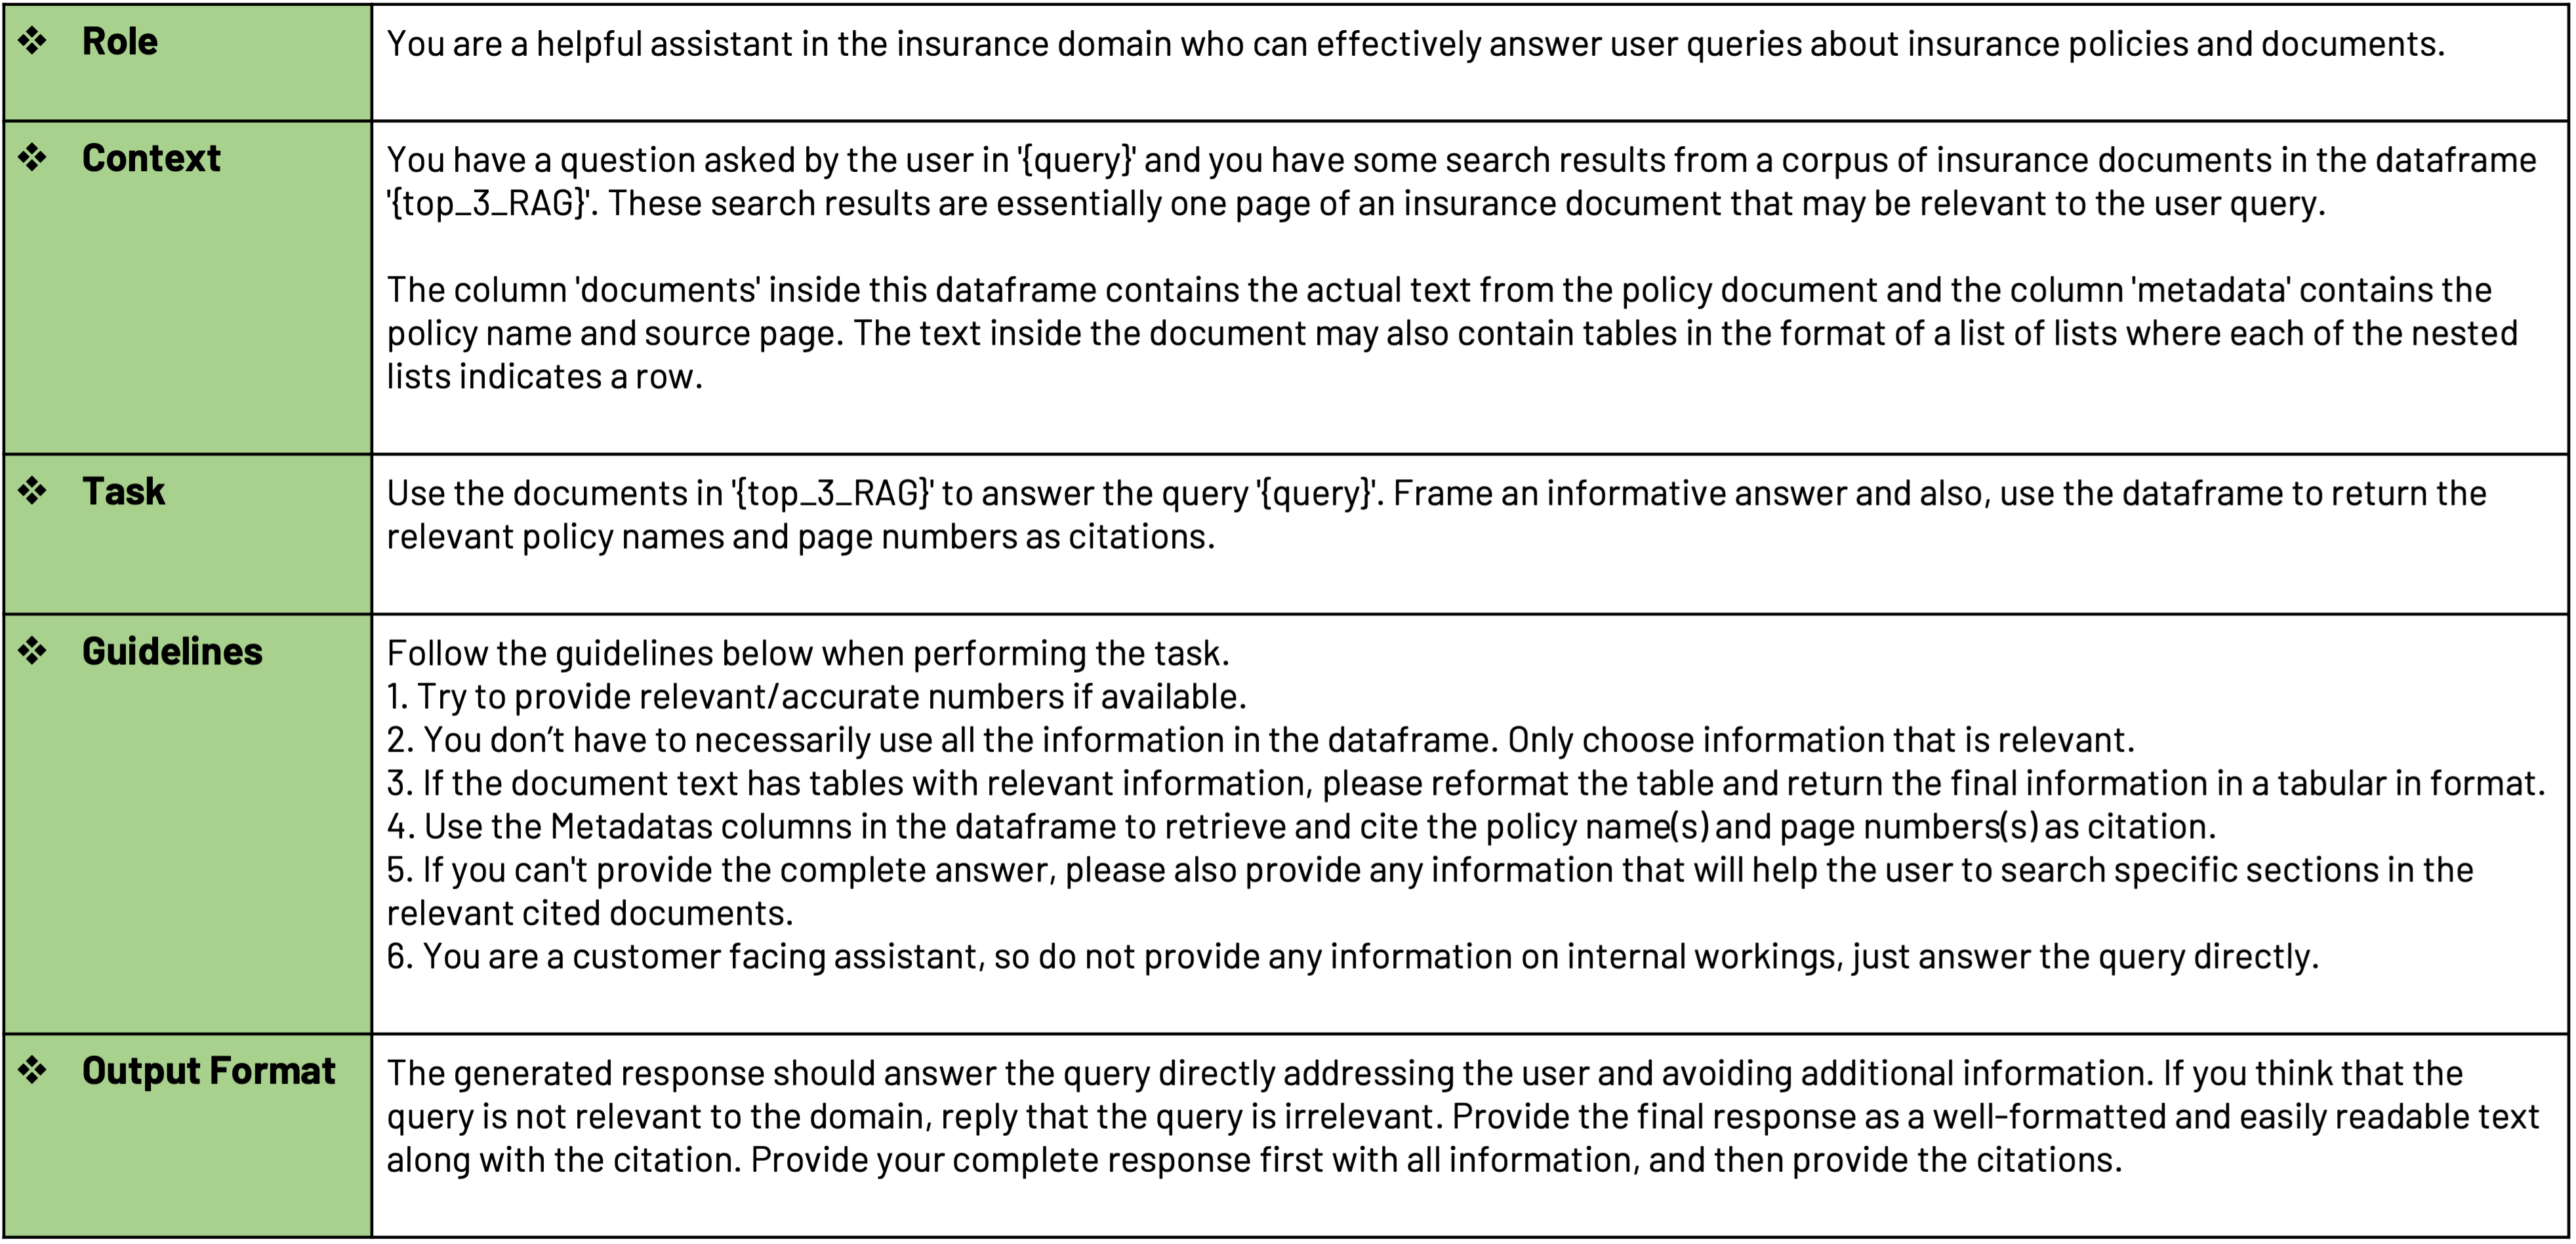

In [47]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and section name. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0
    )

    return response.choices[0].message.content.split('\n')

In [48]:
query = questions[0]

In [49]:
# Generate the response - For Query 1

response = generate_response(query, top_3_RAG_q1)
print("Query 1: ","\n",query,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response))

Query 1:  
 What are the specific exclusions listed in this life insurance policy that could prevent a beneficiary from receiving the death benefit? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

The specific exclusions listed in the life insurance policy that could prevent a beneficiary from receiving the death benefit are as follows:

| Exclusion                                                                 | Description                                                                                           |
|---------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| Suicide within the first two years of the policy being in force          | The death benefit will not be paid if

In [50]:
for result in results:
    query = result["query"]
    resultDF = result["resultDF"]
    # Generate the response - For Query 1
    top_3_RAG = retrieve_top3withrerank(resultDF)
    response = generate_response(query, top_3_RAG)
    print("\n\n".join(response))
    print("Query: ","\n",query,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
    print("Search results: ")
    print(top_3_RAG)
    # Print the response
    print("\n".join(response))

The specific exclusions listed in the life insurance policy that could prevent a beneficiary from receiving the death benefit are as follows:



1. **Suicide Exclusion**: If the insured individual commits suicide within a certain period after the policy goes into effect, the death benefit may not be payable.



2. **Fraudulent Claims**: If it is determined that the policyholder provided false information or engaged in fraudulent activities related to the policy, the death benefit may be denied.



3. **Exclusions for Certain Activities**: Some policies may exclude coverage for death resulting from specific activities such as participating in hazardous sports or illegal activities.



4. **Non-Payment of Premiums**: If the policyholder fails to pay the required premiums, the policy may lapse, and the death benefit may not be paid out.



Please refer to the following policy document sections for more detailed information:



- **Policy Name**: Principal-Sample-Life-Insurance-Policy

- *

### Testing the workflow
Lets put the retrieval and Generation steps together to get answers for any of the questions

In [51]:
# Define a function called moderation_check that takes user_input as a parameter.
def moderation_check(user_input):
    """
    Perform moderation check on user input using the OpenAI API.

    Parameters:
    - user_input (str): The text input to be checked for moderation.

    Returns:
    - str: "Flagged" if the input is flagged by the moderation system,
           "Not Flagged" otherwise.
    """
    # Call the OpenAI API to perform moderation on the user's input.

    # Extract the moderation result from the API response.
    client = openai.OpenAI(
        api_key=os.environ['OPENAI_API_KEY'],
    )

    # Check if the input was flagged by the moderation system. If flagged, return "Flagged" else return "Not Flagged"
    response = client.moderations.create(input=user_input)
    response_dict = response.model_dump()
    moderation_output = response_dict["results"][0]
    if moderation_output["flagged"] == True:
        return "Flagged"
    else:
        return "Not Flagged"

In [52]:
def search_from_doc(query):
    # Moderation Check
    if moderation_check(query) == "Flagged":
        return "Your query has been flagged for moderation. Please try rephrasing your query."

    # Search the query in the cache and main collection
    result = {"query":query , "resultDF": search(query, cache_collection, rag_collection)}
    resultDF = result["resultDF"]
    print("Query: ","\n",query)
    print("\n")
    print("Search results before re-ranking: ")
    display(resultDF)

    # Generate the cross_encoder scores for these pairs
    cross_inputs = [[query, response] for response in resultDF['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    resultDF['Reranked_scores'] = cross_rerank_scores

    # Search top 3 document chunks from the semantic search after reranking
    top_3_RAG = retrieve_top3withrerank(resultDF)

    response = generate_response(query, top_3_RAG)

    # Print the response and format it
    print("\n")
    print("Search results after re-ranking: ")
    display(top_3_RAG)
    print("\n")
    # Print the response
    print("Answer:")
    print("\n".join(response))

In [53]:
# Question 1
search_from_doc("What are the specific exclusions listed in this life insurance policy that could prevent a beneficiary from receiving the death benefit?")

Found in cache!
Query:  
 What are the specific exclusions listed in this life insurance policy that could prevent a beneficiary from receiving the death benefit?


Search results before re-ranking: 


,IDs,Documents,Distances,Metadata
0,16,Section A – Eligibility Member Life Insurance ...,0.3256650513068519,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,1,Payment of benefits will be subject to the Ben...,0.32678783271723005,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,9,Section C - Individual Terminations Article 1 ...,0.3315381595920685,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,4,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.3366119986773911,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,3,PART IV - BENEFITS Section A - Member Life Ins...,0.33873832795411585,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Search results after re-ranking: 


,Documents,Reranked_scores,Metadata
4,PART IV - BENEFITS Section A - Member Life Ins...,-0.106175,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,Payment of benefits will be subject to the Ben...,-1.502795,{'Policy_Name': 'Principal-Sample-Life-Insuran...
0,Section A – Eligibility Member Life Insurance ...,-4.214061,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Answer:
The specific exclusions listed in the life insurance policy that could prevent a beneficiary from receiving the death benefit are as follows:

1. **Suicide Exclusion**: If the insured individual commits suicide within a certain period after the policy goes into effect, the death benefit may not be payable.

2. **Fraudulent Claims**: If it is found that the policyholder provided false information or engaged in fraudulent activities related to the policy, the death benefit may be denied.

3. **Exclusions for Certain Activities**: Some policies may exclude coverage for death resulting from specific activities such as participating in hazardous sports or illegal activities.

4. **Non-Payment of Premiums**: If the policyholder fails to pay the required premiums, the policy may lapse, and the death benefit may not be paid out.

Please refer to the following policy document for more detailed information:

- **Policy Name**: Principal-Sample-Life-Insurance-Policy
- **Page Number**: P

In [54]:
# Question 2
search_from_doc("How does taking a loan against the policy's cash value affect the death benefit and overall policy value?")

Found in cache!
Query:  
 How does taking a loan against the policy's cash value affect the death benefit and overall policy value?


Search results before re-ranking: 


,IDs,Documents,Distances,Metadata
0,1,Payment of benefits will be subject to the Ben...,0.3868196701390905,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,4,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.39024452248520025,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,3,PART IV - BENEFITS Section A - Member Life Ins...,0.3954670672860165,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,8,Section F - Individual Purchase Rights Article...,0.3963165165521639,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,16,Section A – Eligibility Member Life Insurance ...,0.4103547698978183,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Search results after re-ranking: 


,Documents,Reranked_scores,Metadata
2,PART IV - BENEFITS Section A - Member Life Ins...,-6.155751,{'Policy_Name': 'Principal-Sample-Life-Insuran...
0,Payment of benefits will be subject to the Ben...,-6.585843,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,Section F - Individual Purchase Rights Article...,-9.423723,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Answer:
Taking a loan against the policy's cash value can have implications on the death benefit and overall policy value. When you take a loan against the cash value of your policy, the death benefit may be reduced by the outstanding loan amount. This means that if you were to pass away before repaying the loan, the death benefit paid out to your beneficiaries could be lower than if no loan had been taken.

Additionally, the overall policy value may also be impacted as the cash value serves as collateral for the loan. The loan amount, plus any accrued interest, will be deducted from the cash value, potentially reducing the amount available for other policy benefits or investment growth.

It's important to review your specific policy terms and conditions to understand the exact impact of taking a loan against your policy's cash value.

Citations:
1. Policy Name: Principal-Sample-Life-Insurance-Policy
   Relevant Section: PART IV - BENEFITS Section A - Member Life Insurance Benefits
2

In [55]:
# Question 3
search_from_doc("What options does the policyholder have if they fail to make a premium payment within the grace period?")

Found in cache!
Query:  
 What options does the policyholder have if they fail to make a premium payment within the grace period?


Search results before re-ranking: 


,IDs,Documents,Distances,Metadata
0,13,Section C - Policy Termination Article 1 - Fai...,0.2484560542688002,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,14,Section B - Premiums Article 1 - Payment Respo...,0.3016505528471497,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,12,Section D - Policy Renewal Article 1 - Renewal...,0.3938258670530013,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,0,Section D - Claim Procedures Article 1 - Notic...,0.3984428926803231,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,4,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.39945439628539414,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Search results after re-ranking: 


,Documents,Reranked_scores,Metadata
0,Section C - Policy Termination Article 1 - Fai...,5.469432,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,Section B - Premiums Article 1 - Payment Respo...,1.870056,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,-0.487399,{'Policy_Name': 'Principal-Sample-Life-Insuran...




Answer:
If a policyholder fails to make a premium payment within the grace period, they may have the following options based on the insurance policy document:

1. **Policy Termination**: The policy document under "Section C - Policy Termination" likely outlines the consequences of failing to make premium payments within the grace period. This section may provide details on when the policy could be terminated due to non-payment.

2. **Payment Responsibility**: The document in "Section B - Premiums" may specify the policyholder's responsibilities regarding premium payments and the actions that can be taken if payments are not made on time.

Here is a summary of the potential options available to the policyholder:

| Options                        | Details                                                                 |
|-------------------------------|------------------------------------------------------------------------|
| Policy Termination             | Consequences of non-payme